In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import sys
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Circle
import seaborn as sns; 
from IPython.display import HTML

In [3]:
#config parser
import configparser

sys.path.insert(0, '../Common/')
from AISDataManager import AISDataManager
import Constants as c
import HMUtils as hMUtil
import TimeUtils as timeUtils

#MyConfig.INI stores all the run time constants
config = configparser.ConfigParser()
config.read('../MyConfig.INI')

from joblib import Parallel, delayed
import multiprocessing
aISDM = AISDataManager()

In [4]:
lonMin = (float)(config['REGEION']['LON_MIN'])
lonMax = (float)(config['REGEION']['LON_MAX'])

latMin = (float)(config['REGEION']['LAT_MIN'])
latMax = (float)(config['REGEION']['LAT_MAX'])

print(lonMin,latMin)
print(lonMax,latMax)

increStep = (float)(config['HEATMAP']['INCR_STEP'])
incrRes = (int)(config['HEATMAP']['INCR_RES'])

-120.0 31.0
-117.0 34.5


In [5]:
xGrid = np.arange(lonMin,lonMax,increStep)
xGrid = np.around(xGrid,incrRes)
yGrid = np.arange(latMin,latMax,increStep)
yGrid = np.around(yGrid,incrRes)

In [6]:
heatMapDirectory = "../Data/AIS_0117_1217_31_M120_345_M117/HourlyHM/"

heatMapData = []
for i in range(0,8760):
    heatMapFile = heatMapDirectory + str(i) + '.npy'
    heatMapVal = np.load(heatMapFile)
    heatMapData.append(heatMapVal.copy())

In [7]:
#find out the cells on which we want to train our model
#cells with zero entires are not useful to us
#go through every heat map

hMBoolSum = np.zeros((heatMapData[0].shape))
# #iterate through heat maps 
for hM in heatMapData:
    #find instances of heat map
    hMBool = hM > 0
    hMBoolSum = hMBoolSum + hMBool
print(hMBoolSum)

[37. 51. 43. ...  0.  0.  0.]


In [8]:
nonZeroGrid = np.argwhere(hMBoolSum > 100)

nonZeroGrid = nonZeroGrid.flatten()
nonZeroGrid = nonZeroGrid.tolist()

In [9]:
# print(nonZeroGrid)
print(len(nonZeroGrid))

814


In [10]:
def generate_region_data(index, bW):
    #histogram data
    histData = []
    histLabel = []

    #get the row and column of the desired grid
    indexRow, indexCol = hMUtil.get_row_col(index, yGrid.shape[0], xGrid.shape[0])
    
    width = xGrid.shape[0]
    height = yGrid.shape[0]
    
    #now iterate through heatmap files
    for hM in heatMapData:
        #copy the data file
        tempNP = hM.copy()
        
        #reshape it in 2D fashion
        #so that we can levarege the window
        tempNP = np.reshape(tempNP,(yGrid.shape[0],xGrid.shape[0]))
        
        #now slice the array 
        #here it has to be window
        #the regeion we are interested
        #and some cells which are near to this regeion
        leftRow = indexRow-bW
        if(leftRow < 0):
            leftRow = 0
            
        rightRow = indexRow+bW+1
        if(rightRow > height): 
            rightRow = height
            
        leftCol = (indexCol-bW)
        if(leftCol < 0):
            leftCol = 0
            
        rightCol = (indexCol+bW+1)
        if(rightCol > width): 
            rightCol = width
        
            
        histNPX = tempNP[(leftRow):(rightRow),leftCol:rightCol].copy()

        #now append this into the list
        histData.append(histNPX.flatten())

        #after that we have our own regeion
        histNPY = tempNP[indexRow,indexCol].copy()
        
        #we need to add things up for label
        histY = np.sum(histNPY)
        #append that into label
        histLabel.append(histY)
        
    histLabelNP = np.asarray(histLabel)
    return np.asarray(histData),histLabelNP

In [11]:
from sklearn.preprocessing import MinMaxScaler

dataX, dataY = generate_region_data(686,3)
dataY = np.reshape(dataY, (dataY.shape[0],1))

print(dataX.shape)
print(dataY.shape)

scX = MinMaxScaler(feature_range=(0,1)).fit(dataX)
scY = MinMaxScaler(feature_range=(0,1)).fit(dataY)

dataX = scX.transform(dataX)
dataY = scY.transform(dataY)


22 26
(8760, 49)
(8760, 1)


In [12]:
#will make a data set for time series forcast
#will consider how many previous data we want to consider
#will also take the feature matrix 
#and output feature
#will return matrix of reduced dimension
#which can be used as a feature factor
def make_time_series_data(matX,matY,pastFeatures,futureFeature = 0):
    #first make data set for time series regression
    #so based on past features to consider
    #we will have data set limited by that number
    noRowsX = matX.shape[0] - pastFeatures - futureFeature

    #initialise m*n dimensional array for X(where n is number of past features)
    #where m is total number data points for the training and testing
    #m will be noRowsX
    retXMat = np.zeros(shape=(noRowsX,(pastFeatures*matX.shape[1])))
        
    #initialise noRowsX*column dimensional array for Y
    retYMat = np.zeros(shape=(noRowsX))
    
                       
    for i in range(0,noRowsX):
        #numpy array with zero element
        temp = np.zeros(0)
        
        for j in range(i,i+pastFeatures):
            temp = np.append(temp,matX[j])
        retXMat[i] = temp
        retYMat[i] = matY[i+pastFeatures+futureFeature]
    return retXMat,retYMat,noRowsX

In [13]:
dataXTS,dataYTS,noOfSamples = make_time_series_data(dataX,dataY,3)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import r2_score


dataXTrain,dataXTest,dataYTrain,dataYTest = train_test_split(dataXTS\
                                                             ,dataYTS\
                                                             ,train_size = 0.8\
                                                             ,test_size = 0.2\
                                                             ,shuffle = False\
                                                            )

In [15]:
dataXTrain = np.reshape(dataXTrain,(dataXTrain.shape[0],3, dataXTrain.shape[1]//3))
dataXTest = np.reshape(dataXTest,(dataXTest.shape[0],3, dataXTest.shape[1]//3))
print(dataXTrain.shape)
print(dataXTest.shape)

(7005, 3, 49)
(1752, 3, 49)


In [16]:
from keras import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [17]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

W0904 10:06:02.923606 139723839113024 deprecation_wrapper.py:119] From /home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0904 10:06:02.924270 139723839113024 deprecation_wrapper.py:119] From /home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0904 10:06:02.924665 139723839113024 deprecation_wrapper.py:119] From /home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0904 10:06:03.204010 139723839113024 deprecation_wrapper.py:119] From /home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: T

['/job:localhost/replica:0/task:0/device:GPU:0']

In [18]:
from keras import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(dataXTrain.shape[1],dataXTrain.shape[2])))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))

model.compile(loss='mae', optimizer='adam')

W0904 10:06:03.225847 139723839113024 deprecation_wrapper.py:119] From /home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 10:06:03.622868 139723839113024 deprecation_wrapper.py:119] From /home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [19]:
model.fit(dataXTrain, dataYTrain, epochs=50, batch_size=32)

W0904 10:06:03.797242 139723839113024 deprecation.py:323] From /home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
7005/7005 [==============================] - 6s 873us/step - loss: 0.0849
Epoch 2/50
7005/7005 [==============================] - 4s 503us/step - loss: 0.0575
Epoch 3/50
7005/7005 [==============================] - 4s 559us/step - loss: 0.0544
Epoch 4/50
7005/7005 [==============================] - 4s 556us/step - loss: 0.0526
Epoch 5/50
7005/7005 [==============================] - 4s 535us/step - loss: 0.0510
Epoch 6/50
7005/7005 [==============================] - 4s 516us/step - loss: 0.0489
Epoch 7/50
7005/7005 [==============================] - 3s 479us/step - loss: 0.0465
Epoch 8/50
7005/7005 [==============================] - 4s 540us/step - loss: 0.0451
Epoch 9/50
7005/7005 [==============================] - 3s 483us/step - loss: 0.0451
Epoch 10/50
7005/7005 [==============================] - 4s 528us/step - loss: 0.0443
Epoch 11/50
7005/7005 [==============================] - 4s 534us/step - loss: 0.0427
Epoch 12/50
7005/7005 [==============================] - 4s 592

In [20]:
predTrain = model.predict(dataXTrain)
predTest = model.predict(dataXTest)

In [21]:
dataYTest = np.reshape(dataYTest,(dataYTest.shape[0],1))
predTest = np.reshape(predTest,(predTest.shape[0],1))

In [22]:
dataYTest = scY.inverse_transform(dataYTest)
predTest = scY.inverse_transform(predTest)

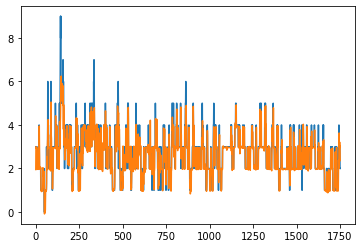

In [23]:
plt.plot(dataYTest)
plt.plot(predTest)

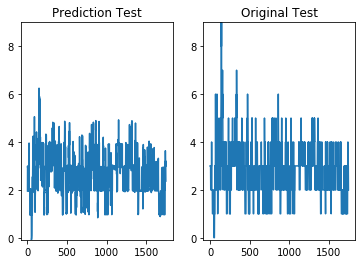

In [24]:
ax1 = plt.subplot(1,2,1)
ax1.set_ylim(min(np.min(predTest),np.min(dataYTest)),max(np.max(predTest),np.max(dataYTest)))
ax1.plot(predTest)
ax1.set_title("Prediction Test")

ax1 = plt.subplot(1,2,2)
ax1.set_ylim(min(np.min(predTest),np.min(dataYTest)),max(np.max(predTest),np.max(dataYTest)))
ax1.plot(dataYTest)
ax1.set_title("Original Test")
plt.savefig("TestData")

In [25]:
# fit_transform
print(predTest.shape)
print(dataYTest.shape)

(1752, 1)
(1752, 1)


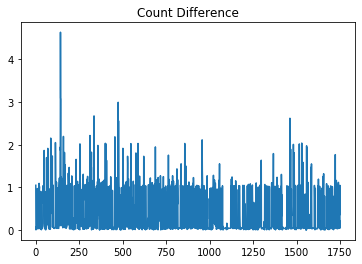

In [26]:
fig, ax = plt.subplots()
diff = abs(predTest.flatten() - dataYTest.flatten())
ax.set_title("Count Difference")
ax.plot(diff)
# plt.savefig("CountDiff.png")